In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import bayesian as bst

In [3]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\page.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df.info()
print("Jumlah user unik:", df['user_id'].nunique())
print("Jumlah user duplikat:", df.shape[0] - df['user_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
Jumlah user unik: 290584
Jumlah user duplikat: 3894


In [6]:
df = df.drop_duplicates('user_id', keep='first')

In [8]:
control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']

conv_control = control['converted'].sum()
conv_treatment = treatment['converted'].sum()

n_control = len(control)
n_treatment = len(treatment)

print(f"\nConversion rate control: {conv_control/n_control:.4f}")
print(f"Conversion rate treatment: {conv_treatment/n_treatment:.4f}")


Conversion rate control: 0.1203
Conversion rate treatment: 0.1188


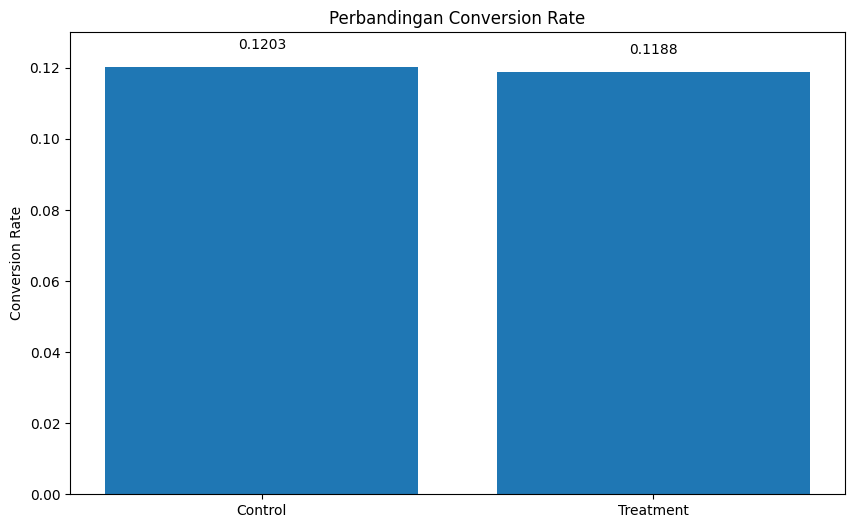

In [9]:
plt.figure(figsize=(10,6))
plt.bar(['Control', 'Treatment'], [conv_control/n_control, conv_treatment/n_treatment])
plt.ylabel('Conversion Rate')
plt.title('Perbandingan Conversion Rate')
plt.ylim(0, 0.13)
for i, v in enumerate([conv_control/n_control, conv_treatment/n_treatment]):
    plt.text(i, v+0.005, f"{v:.4f}", ha='center')
plt.show()

In [10]:
count = np.array([conv_treatment, conv_control])
nobs = np.array([n_treatment, n_control])
z_stat, pval = proportions_ztest(count, nobs)
print(f"\nZ-test p-value: {pval:.4f}")

ci = confint_proportions_2indep(conv_treatment, n_treatment, conv_control, n_control)
print(f"95% CI untuk perbedaan proporsi: ({ci[0]:.4f}, {ci[1]:.4f})")

effect_size = sms.proportion_effectsize(conv_control/n_control, conv_treatment/n_treatment)
power = sms.TTestIndPower().solve_power(
    effect_size=effect_size,
    nobs1=n_treatment,
    alpha=0.05,
    power=None
)
print(f"\nPower test: {power:.4f}")


Z-test p-value: 0.2269
95% CI untuk perbedaan proporsi: (-0.0038, 0.0009)

Power test: 0.2270


In [11]:
prior_alpha = 1
prior_beta = 1

posterior_control = stats.beta(prior_alpha + conv_control, prior_beta + n_control - conv_control)
posterior_treatment = stats.beta(prior_alpha + conv_treatment, prior_beta + n_treatment - conv_treatment)

samples = 100000
samples_control = posterior_control.rvs(samples)
samples_treatment = posterior_treatment.rvs(samples)
prob = (samples_treatment > samples_control).mean()

print(f"\nProbabilitas treatment lebih baik dari control: {prob:.4f}")


Probabilitas treatment lebih baik dari control: 0.1122


In [12]:
loss_control = np.maximum(samples_treatment - samples_control, 0).mean()
loss_treatment = np.maximum(samples_control - samples_treatment, 0).mean()
print(f"Expected loss control: {loss_control:.4f}")
print(f"Expected loss treatment: {loss_treatment:.4f}")

Expected loss control: 0.0001
Expected loss treatment: 0.0015


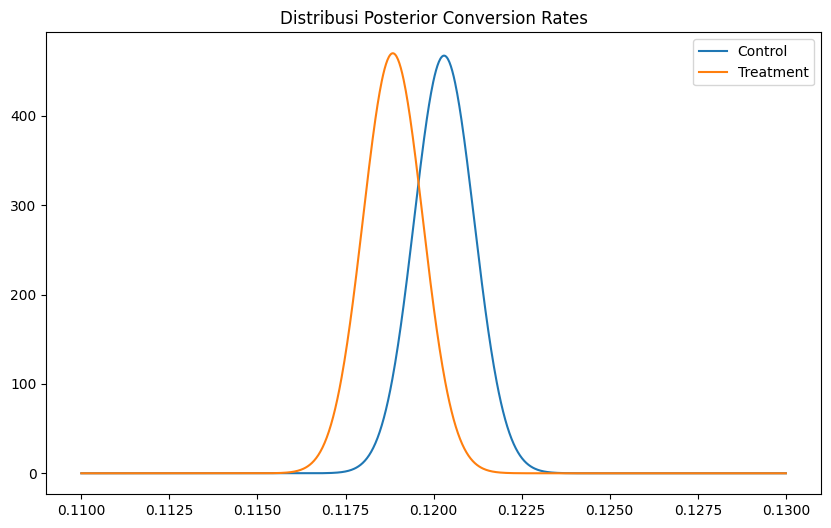

In [13]:
plt.figure(figsize=(10,6))
x = np.linspace(0.11, 0.13, 1000)
plt.plot(x, posterior_control.pdf(x), label='Control')
plt.plot(x, posterior_treatment.pdf(x), label='Treatment')
plt.title('Distribusi Posterior Conversion Rates')
plt.legend()
plt.show()